# 綱要

- 第一部分 : 使用CCR評價美式選擇權
- 第二部分 : 呈現ChatGPT的做法並與自己的做法比較優劣

# 第一部分
使用CCR評價美式選擇權

# 導入套件

In [1]:
import math
import numpy as np 
from scipy.stats import norm
import time
import matplotlib.pyplot as plt

# 設定參數

# Step 1 建立股價二項樹

### 1-1 做法概念

### 1-2 定義函數

In [2]:
def tree_stock(S0:float, T:float, sigma:float, n:int) -> np.array:
    
    # 設定相關變數
    
    dt = T / n  # 每期長度
    u = math.exp( sigma*math.sqrt(dt) )  # 股價上漲倍數
    d = 1 / u  # 股價下跌倍數
    
    # 建立股價二項樹
    
    S = np.zeros( (n+1,n+1) )  # 建立一個 n*n的空矩陣，後面再填入股價
    S[0,0] = S0  # t=0時股價為S0
    
        # 注意，按照下方第二個迴圈內的寫法，t跟i之關係如下  
        # t=1時i=0
        # t=2時i=0,1
        # t=3時i=0,1,2
        # t=n時i=0,1,...,n-1
        # 故，需要一個變數a控制i的變化
    
    a = 1
    for t in range(1,n+1) :  # 將數值填入空矩陣中        
        for i in range(a) :
            S[i,t] = S[i,t-1] * u
            S[i+1,t] = S[i,t-1] * d
        a +=1
        
    return S

In [3]:
tree_stock(S0=30, T=1.0, sigma=0.2, n=4)

array([[30.        , 33.15512754, 36.64208274, 40.49576423, 44.75474093],
       [ 0.        , 27.14512254, 30.        , 33.15512754, 36.64208274],
       [ 0.        ,  0.        , 24.56192259, 27.14512254, 30.        ],
       [ 0.        ,  0.        ,  0.        , 22.22454662, 24.56192259],
       [ 0.        ,  0.        ,  0.        ,  0.        , 20.10960138]])

# Step 2 計算選擇權價格

### 2-1 做法和概念

### 2-2 美式買權函數

In [4]:
def American_call(S0, K, r, T, sigma, n) -> np.array :
    
    # 設定相關變數
    
    dt = T / n  # 每期長度
    u = math.exp( sigma*math.sqrt(dt) )  # 股價上漲倍數
    d = 1 / u  # 股價下跌倍數
    prob = ( math.exp(r*dt) - d ) / (u - d)  # 風險中立機率
    
    # 建立買權二項樹
    
    S = tree_stock(S0, T, sigma, n)  # 引入股價二項樹
    C = np.zeros((n+1,n+1))  # 建立買權空矩陣，後面再填入數值
    
    # 先計算買權到期日價值
        
    C[:,-1] = np.maximum( S[:, -1] - K, 0 )   
                  
    # 基於二項樹向前計算    
        
    t = n   # 基於下面迴圈做法，需先給定初始值
    b = n   # 此變化規律見2-1的i變化
    while not t < 1 :  # 只要t不等於0，就一直執行下面迴圈(一直折現至t=0)
        for i in range(b) :
            hold_option_value = math.exp(-r*dt) * ( C[i,t]*prob + C[i+1,t]*(1-prob) )  # 計算第t-1期持有選擇權的期望價值(由第t期折現而來)
            strike_value = S[i,t-1] - K  # 計算第t-1期提前履約能得到的履約價值
            C[i,t-1] = max( hold_option_value, strike_value )  # 持有選擇權價值和履約價值取大作為下次計算的選擇權價值
        t = t - 1  # 因CRR是由後往前計算，故時間(期數)為遞減至t=0
        b = b - 1
        
    Call = C[0,0]
        
    return Call

### 2-3 美式賣權函數

In [5]:
def American_put(S0, K, r, T, sigma, n) -> np.array :
    
    # 設定相關變數
    
    dt = T / n  # 每期長度
    u = math.exp( sigma*math.sqrt(dt) )  # 股價上漲倍數
    d = 1 / u  # 股價下跌倍數
    prob = ( math.exp(r*dt) - d ) / (u - d)  # 風險中立機率
    
    # 建立賣權二項樹
    
    S = tree_stock(S0, T, sigma, n)  # 引入股價二項樹
    P = np.zeros((n+1,n+1))  # 建立賣權空矩陣，後面再填入數值
    
    # 先計算賣權到期日價值
    
    P[:,-1] = np.maximum( K - S[:,-1], 0 )
   
    # 基於二項樹向前計算 
        
    t = n   # 基於下面迴圈做法，需先給定初始值
    b = n   # 此變化規律見2-1
    while not t < 1 :  # 只要t不等於0，就一直執行下面迴圈(一直折現至t=0)
        for i in range(b) :
            hold_option_value = math.exp(-r*dt) * ( P[i,t]*prob + P[i+1,t]*(1-prob) )  # 計算在第t-1期持有選擇權的期望價值(由第t期折現而來)
            strike_value = K - S[i,t-1]   # 計算第t-1期提前履約能得到的履約價值
            P[i,t-1] = max( hold_option_value, strike_value )   # 持有選擇權價值和履約價值取大作為下次計算的選擇權價值
        t = t - 1  # 因CRR是由後往前計算，故時間(期數)為遞減至t=0
        b = b - 1 
        
    Put = P[0,0]
        
    return Put

## Step 3 計算結果

In [6]:
American_call(S0=100, K=100, r=0.1, T=1.0, sigma=0.3, n=1000)

16.731155968970015

In [7]:
American_put(S0=100, K=100, r=0.1, T=1.0, sigma=0.3, n=1000)

8.336577032394455

##  Step 4 用圖形展示收斂過程

### 4-1 先以Black_Scholes Model計算出選擇權價格，作為收斂目標

In [8]:
def BS_option_price(S0, K, r, T, sigma) -> float :
    
    # 設定參數
    
    d1 = ( np.log(S0/K) + (r + (sigma**2/2) )*T ) / (sigma*np.sqrt(T) )
    d2 = d1 - sigma*np.sqrt(T)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    # 計算選擇權價格
    
    call = S0*N_d1 - K*np.exp(-r*T)*N_d2
    put = K*np.exp(-r*T)*( 1 - N_d2 ) - S0*( 1 - N_d1 )
    
    return call,put

In [9]:
BS_Call,BS_Put = BS_option_price(S0=100, K=100, r=0.1, T=1.0, sigma=0.3)

In [10]:
BS_Call

16.73413358238666

In [11]:
BS_Put

7.217875385982609

### 4-2 再透過CRR展示收斂過程

In [12]:
n_list = []  # 期數list
for i in range(1,101) :  # n:1~100
    n_list.append(i)

In [13]:
# 盛裝後面計算出來的各種買、賣權價格

Call_list = []
Put_list = []

# 計算不同期數下的選擇權價格

for i in n_list :  # 期數範圍:n=1~100
    call_prices = American_call(S0=100, K=100, r=0.1, T=1.0, sigma=0.3, n=i)
    put_prices = American_put(S0=100, K=100, r=0.1, T=1.0, sigma=0.3, n=i)
    Call_list.append( call_prices )
    Put_list.append( put_prices )

### 4-3 畫圖展示收斂過程

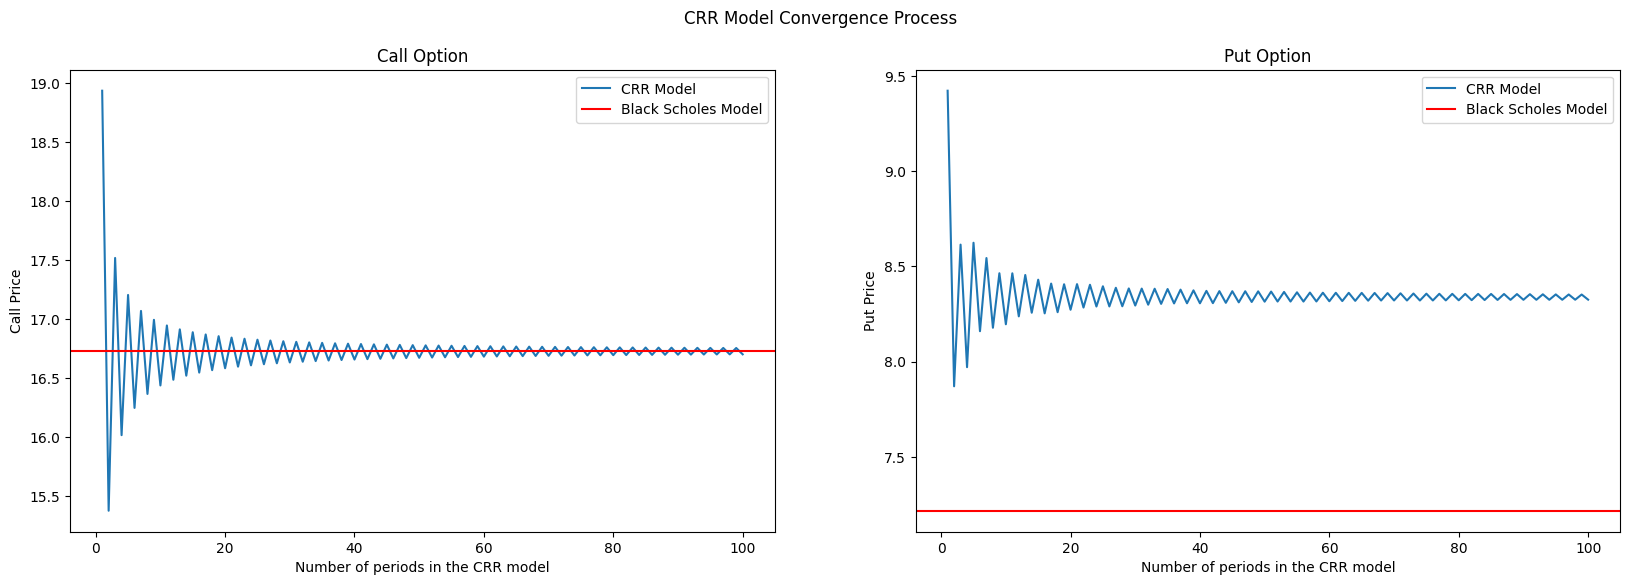

In [14]:
#  設定全圖參數

fig = plt.figure( figsize=(20,6) )  # 全圖大小
fig.suptitle('CRR Model Convergence Process')  # 全圖總標題

# 設定子圖參數(繪製1*2的子圖)

# 第一個子圖(左)，展示Call

plt.subplot(121)  # 前兩個代碼「12」表共有1*2個子圖，第三個代碼「1」表第一個子圖
plt.plot(n_list, Call_list, label='CRR Model')
plt.title('Call Option')
plt.xlabel('Number of periods in the CRR model')
plt.ylabel('Call Price')
plt.axhline(y=BS_Call, color='r', label='Black Scholes Model')
plt.legend(loc=0)

# 第二個子圖(右)，展示Put

plt.subplot(122)
plt.plot(n_list, Put_list, label='CRR Model')
plt.title('Put Option')
plt.xlabel('Number of periods in the CRR model')
plt.ylabel('Put Price')
plt.axhline(y=BS_Put, color='r', label='Black Scholes Model')
plt.legend(loc=0)

### Step 5 展示「不同股價下美式選擇權和歐式選擇權之差異」

In [15]:
current_stock_price = []  # 股價list
for i in range(1,201) :  # 現在股價 : 1~200
    current_stock_price.append(i)

In [16]:
call_price_us_ccr = []  # 盛裝CRR計算出來的美式買權價格
call_price_eu_bs = []  # 盛裝Black Scholes Model計算出來的歐式買權價格

put_price_us_ccr = []  # 盛裝CRR計算出來的美式賣權價格
put_price_eu_bs = []  # 盛裝Black Scholes Model計算出來的歐式賣權價格

# 分別計算在不同股價下，CRR和Black Scholes Model的歐、美式的買賣權價格

for i in current_stock_price :
    
    temp_call_us_ccr = American_call(S0=i, K=100, r=0.1, T=1.0, sigma=0.3, n=100)
    temp_put_us_ccr = American_put(S0=i, K=100, r=0.1, T=1.0, sigma=0.3, n=100)
    call_price_us_ccr.append( temp_call_us_ccr )
    put_price_us_ccr.append( temp_put_us_ccr )
    
    temp_call_eu_bs, temp_put_eu_bs = BS_option_price(S0=i, K=100, r=0.1, T=1.0, sigma=0.3)
    call_price_eu_bs.append( temp_call_eu_bs )
    put_price_eu_bs.append( temp_put_eu_bs )

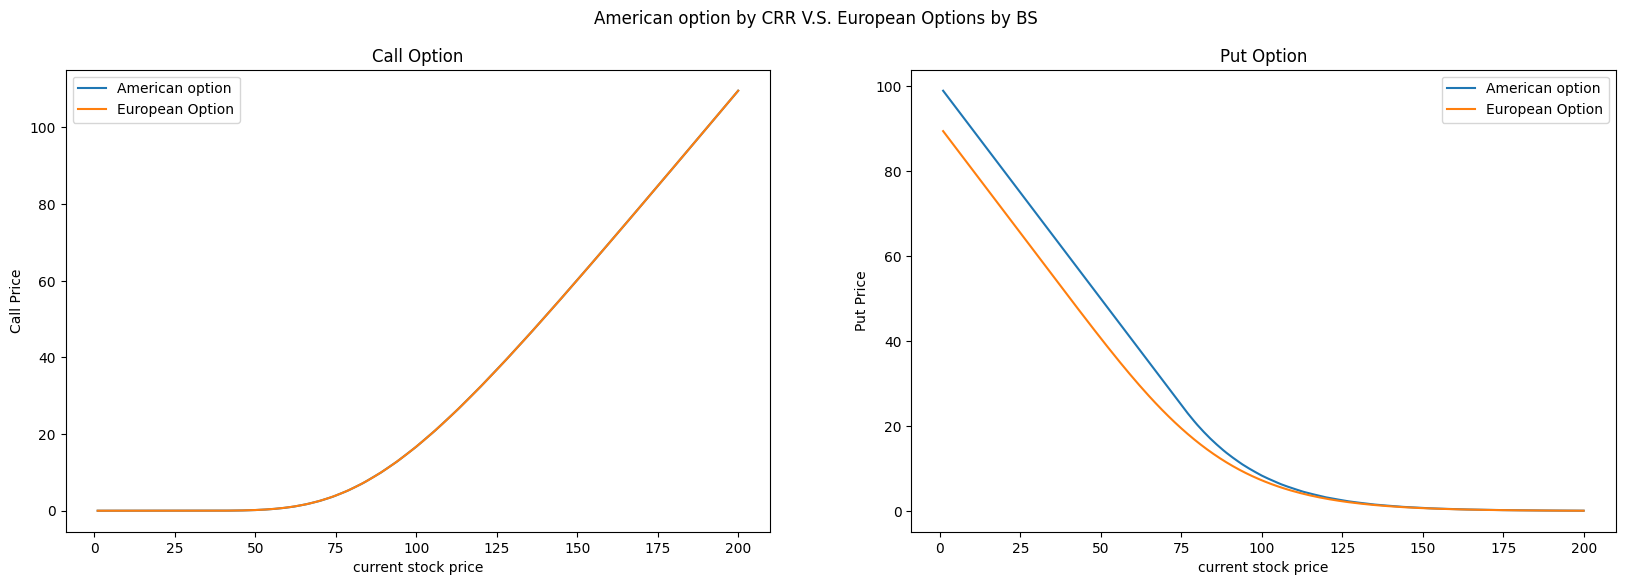

In [17]:
#  設定全圖參數

fig = plt.figure( figsize=(20,6) )  # 全圖大小
fig.suptitle('American option by CRR V.S. European Options by BS')  # 全圖總標題

# 設定子圖參數(繪製1*2的子圖)

# 第一個子圖(左)，展示Call

plt.subplot(121)  # 前兩個代碼「12」表共有1*2個子圖，第三個代碼「1」表第一個子圖
x = current_stock_price
y1 = call_price_us_ccr
y2 = call_price_eu_bs
plt.plot(x, y1, label = 'American option')
plt.plot(x, y2, label = 'European Option')
plt.title('Call Option')
plt.xlabel('current stock price')
plt.ylabel('Call Price')
plt.legend(loc=0)

# 第二個子圖(右)，展示Put

plt.subplot(122)
x = current_stock_price
y1 = put_price_us_ccr
y2 = put_price_eu_bs
plt.plot(x, y1, label = 'American option')
plt.plot(x, y2, label = 'European Option')
plt.title('Put Option')
plt.xlabel('current stock price')
plt.ylabel('Put Price')
plt.legend(loc=0)

# 第二部分
透過ChatGPT做出CRR

下方產生自ChatGPT(修正前，只展示買權)

### ChatGPT買權(修正後)

In [18]:
import math

def calculate_option_price(S, X, r, T, sigma, N):
    # 計算相關變量
    delta_t = T / N
    u = math.exp(sigma * math.sqrt(delta_t))
    d = 1 / u
    discount_factor = math.exp(-r * delta_t)
    prob = ( math.exp(r*delta_t) - d ) / (u - d)  ## 修正處1

    # 創建二叉樹
    stock_prices = [[S]]
    for i in range(1, N + 1):
        prev_prices = stock_prices[i - 1]
        current_prices = [prev_prices[0] * u]
        for j in range(1, i + 1):
            current_prices.append(prev_prices[j - 1] * d)
        stock_prices.append(current_prices)

    # 計算期末價值
    option_values = [[max(0, price - X) for price in prices] for prices in stock_prices]

    # 向前歸納計算期權價格
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            exercise_value = max(0, stock_prices[i][j] - X)
            option_value = discount_factor*(prob * option_values[i + 1][j] + (1 - prob) * option_values[i + 1][j + 1])  ## 修正處2
            option_values[i][j] = max(exercise_value, option_value)

    # 返回期權價格
    return option_values[0][0]

# 參數
S = 100  # 目前股價
X = 100  # 履約價
r = 0.1  # 無風險利率
T = 1  # 權利期間（年）
sigma = 0.3  # 波動度
N = 1000  # 期數

# 計算美式買權價格
option_price = calculate_option_price(S, X, r, T, sigma, N)
print("美式買權價格:", option_price)

美式買權價格: 16.731155968969958


### ChatGPT賣權(修正後)

In [19]:
def calculate_put_option_price(S, K, r, T, sigma, n):
    dt = T / n
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    discount_factor = math.exp(-r * dt)
    p = (math.exp(r * dt) - d) / (u - d)

    # 計算股價的二項樹
    stock_prices = np.zeros((n + 1, n + 1))
    stock_prices[0, 0] = S
    for i in range(1, n + 1):
        stock_prices[i, 0] = stock_prices[i - 1, 0] * u
        for j in range(1, i + 1):
            stock_prices[i, j] = stock_prices[i - 1, j - 1] * d

    # 計算期權價值的二項樹
    option_values = np.zeros((n + 1, n + 1))
    for j in range(n + 1):
        option_values[n, j] = max(K - stock_prices[n, j], 0)

    # 從後往前計算期權價格
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            exercise_value = max(K - stock_prices[i, j], 0)
            continuation_value = discount_factor * (p * option_values[i + 1, j] + (1 - p) * option_values[i + 1, j + 1])
            option_values[i, j] = max(exercise_value, continuation_value)

    return option_values[0, 0]

# 測試程式碼
S = 100
K = 100
r = 0.1
T = 1
sigma = 0.3
n = 1000

put_option_price = calculate_put_option_price(S, K, r, T, sigma, n)
print("美式賣權價格:", put_option_price)

美式賣權價格: 8.336577032394466


### 展示ChatGPT做法的收斂過程

In [20]:
N_list = []
for i in range(1,101) :  # n:1~100
    N_list.append(i)

In [21]:
Call_list_2 = []
Put_list_2 = []

S = 100  # 目前股價
X = 100  # 履約價
r = 0.1  # 無風險利率
T = 1  # 權利期間（年）
sigma = 0.3  # 波動度

for i in N_list :  # 計算在不同n之下買權價格
    call_price = calculate_option_price(S, X, r, T, sigma, i)
    put_price = calculate_put_option_price(S, K, r, T, sigma, i)
    Call_list_2.append(call_price)
    Put_list_2.append(put_price)

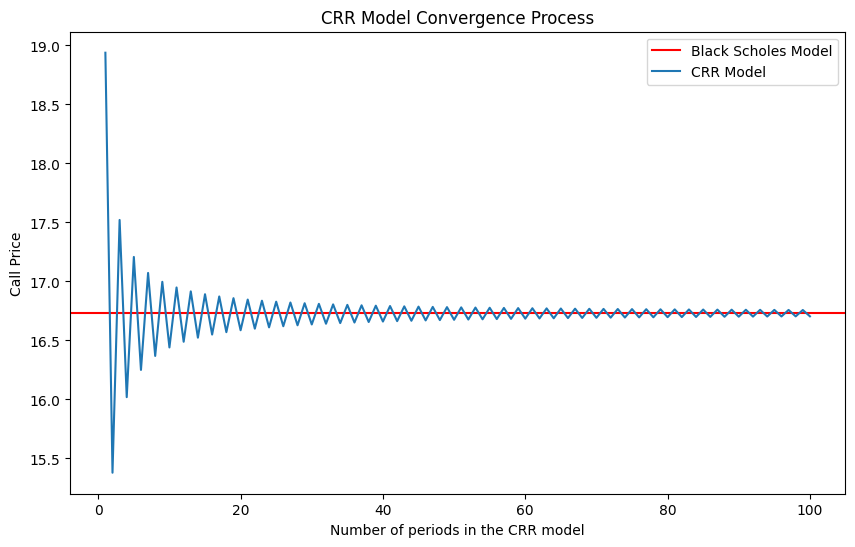

In [22]:
plt.figure( figsize=(10,6) )  # 全圖大小
plt.title('CRR Model Convergence Process')  # 設定標題
plt.xlabel('Number of periods in the CRR model')  # 設定x軸名稱
plt.ylabel('Call Price')  # 設定Y軸名稱
plt.axhline(y=BS_Call, color='r', label='Black Scholes Model')  # 在y=BS_Call的地方畫一條水平紅線
plt.plot(N_list, Call_list_2, label='CRR Model')  # 對「x=N_list,y=Call_list_2」畫圖
plt.legend(loc=0)  # 新增圖例

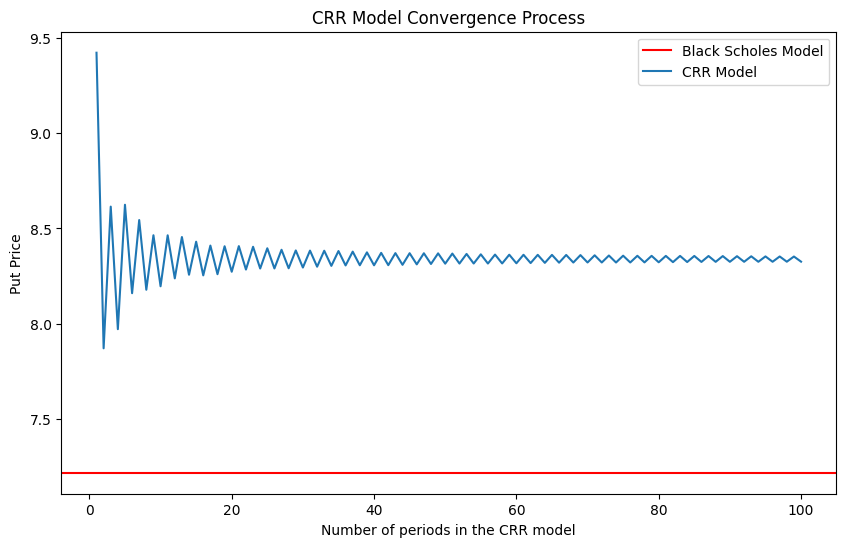

In [23]:
plt.figure( figsize=(10,6) )  # 全圖大小
plt.title('CRR Model Convergence Process')  # 設定標題
plt.xlabel('Number of periods in the CRR model')  # 設定x軸名稱
plt.ylabel('Put Price')  # 設定Y軸名稱
plt.axhline(y=BS_Put, color='r', label='Black Scholes Model')  # 在y=BS_Put的地方畫一條水平紅線
plt.plot(N_list, Put_list_2, label='CRR Model')  # 對「x=N_list,y=Put_list_2」畫圖
plt.legend(loc=0)  # 新增圖例

### 比較「我的做法」和「ChatGPT的做法」之運算速度

- 只比較買權

In [24]:
# 我的做法
    # 整體
start_time_1 = time.time() 
American_call(S0=100, K=100, r=0.1, T=1.0, sigma=0.3, n=1000)
end_time_1 = time.time()
    # 股價二項樹
start_time_11 = time.time()
tree_stock(S0=100, T=1.0, sigma=0.2, n=1000)  # 股價二元數
end_time_11 = time.time()

In [25]:
# ChatGPT的做法
    # 整體
start_time_2 = time.time()
calculate_option_price(S=100, X=100, r=0.1, T=1.0, sigma=0.3, N=1000)
end_time_2 = time.time()
    # 股價二元樹
start_time_21 = time.time()

S = 100
K = 100
r = 0.1
T = 1
sigma = 0.3
n = 1000
dt = T / n
u = math.exp(sigma * math.sqrt(dt))
d = 1 / u
stock_prices = [[S]]
for i in range(1, n + 1):
    prev_prices = stock_prices[i - 1]
    current_prices = [prev_prices[0] * u]
    for j in range(1, i + 1):
        current_prices.append(prev_prices[j - 1] * d)
    stock_prices.append(current_prices)
    
end_time_21 = time.time()

In [26]:
me = end_time_1 - start_time_1  # 整體
me_11 = end_time_11 - start_time_11  # 股價二元樹
ratio_11 = round( (me_11/me)*100, 2 )
me_12 = me - me_11  # 買權計算時間
ratio_12 = 100 - ratio_11
ChatGPT = end_time_2 - start_time_2  # 整體
ChatGPT_21 = end_time_21 - start_time_21  # 股價二元樹
ratio_21 = round( (ChatGPT_21/ChatGPT)*100, 2 )
ChatGPT_22 = ChatGPT - ChatGPT_21  # 買權計算時間
ratio_22 = 100 - ratio_21
print('我的做法')
print(f'  整體計算時間 = {me} 秒')
print(f'  股價二元樹建構時間 = {me_11} 秒，比例 = {ratio_11} %')
print(f'  買權計算時間 = {me_12} 秒，比例 = {ratio_12} %')
print('ChatGPT的做法')
print(f'  整體計算時間 = {ChatGPT} 秒')
print(f'  股價二元樹建構時間 = {ChatGPT_21} 秒，比例 = {ratio_21} %')
print(f'  買權計算時間 = {ChatGPT_22} 秒，比例 = {ratio_22} %')

我的做法
  整體計算時間 = 106.58577013015747 秒
  股價二元樹建構時間 = 39.503477334976196 秒，比例 = 37.06 %
  買權計算時間 = 67.08229279518127 秒，比例 = 62.94 %
ChatGPT的做法
  整體計算時間 = 58.541362285614014 秒
  股價二元樹建構時間 = 10.06203842163086 秒，比例 = 17.19 %
  買權計算時間 = 48.479323863983154 秒，比例 = 82.81 %
